In [1]:
import os
import os.path
my_path = os.path.abspath(os.path.dirname('__file__'))
#path = os.path.join(my_path, "../data/test.csv")
#train_dir = os.path.join(my_path, '..\\..\\aclImdb\\test')
train_dir = os.path.join(my_path, '..\\..\\dataset\\aclImdb\\train')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg' :
                labels.append(0)
            else:
                labels.append(1)
texts[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [2]:
labels[0]

0

In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np

maxlen = 100
training_samples = 2000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 88582 unique tokens.


In [43]:
#len(sequences)
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [44]:
#reshuffle both data/labels reference of indices
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train=data[:training_samples]
y_train=labels[:training_samples]

x_val = data[training_samples: training_samples+validation_samples]
y_val = labels[training_samples: training_samples+validation_samples]

In [45]:
y_train.shape

(2000,)

In [46]:
glove_dir = os.path.join(my_path, '..\\..\\dataset\\glove.6B')

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



In [47]:

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [48]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(10000, 100)

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [50]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data = (x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 2000 samples, validate on 10000 samples
Epoch 1/10
2000/2000 [==============================] - 1s 397us/step - loss: 0.8854 - acc: 0.5065 - val_loss: 0.8126 - val_acc: 0.4905
Epoch 2/10
2000/2000 [==============================] - 1s 289us/step - loss: 0.6800 - acc: 0.6155 - val_loss: 0.9423 - val_acc: 0.4922
Epoch 3/10
2000/2000 [==============================] - 1s 284us/step - loss: 0.5674 - acc: 0.7125 - val_loss: 0.9732 - val_acc: 0.5110
Epoch 4/10
2000/2000 [==============================] - 1s 286us/step - loss: 0.5205 - acc: 0.7415 - val_loss: 1.1070 - val_acc: 0.5116
Epoch 5/10
2000/2000 [==============================] - 1s 290us/step - loss: 0.4318 - acc: 0.8025 - val_loss: 0.8600 - val_acc: 0.4951
Epoch 6/10
2000/2000 [==============================] - 1s 285us/step - loss: 0.3624 - acc: 0.8340 - val_loss: 0.9928 - val_acc: 0.4891
Epoch 7/10
2000/2000 [==============================] - 1s 284us/step - loss: 0.2901 - acc: 0.8820 - val_loss: 1.1683 - val_acc: 0.5035

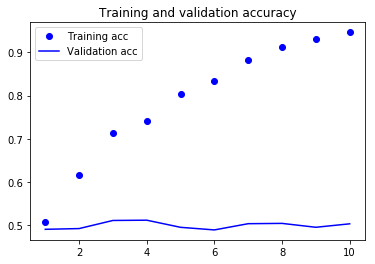

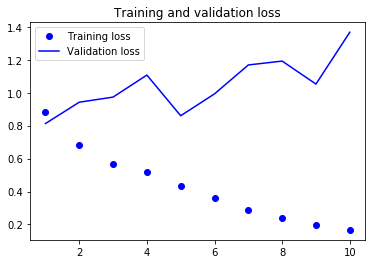

In [53]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

